In [102]:
import pandas as pd
import folium
import math
import seaborn as sns
import requests

In [138]:
pubs = pd.read_csv('https://raw.githubusercontent.com/AJReeves1234/IBM-Capstone-Project/master/open_pubs.csv')

# Exploring the pubs dataset

### For the purpose of this report, I have decided I will be opening my pub in Liverpool (also because we can only make x amounts of location requests for free!


In [139]:
pubs['local_authority'].value_counts().head(10)

County Durham        679
Wiltshire            626
Leeds                624
Cornwall             586
Kirklees             562
Liverpool            494
City of Edinburgh    486
Bradford             475
Northumberland       455
Bristol, City of     444
Name: local_authority, dtype: int64

In [206]:
pubs = pubs[pubs['local_authority']=='Liverpool'].reset_index()

In [207]:
print(pubs.columns)

#converting lat and long to float types else nan for deletion
def to_float(x):
    try:
        out = float(x)
    except:
        out = math.nan
    return out 
        
pubs['latitude'] = pubs['latitude'].apply(lambda x: to_float(x))
pubs['longitude'] = pubs['longitude'].apply(lambda x: to_float(x))

pubs['latitude'].dropna(inplace=True)
pubs['longitude'].dropna(inplace=True)

Index(['level_0', 'index', 'fas_id', 'name', 'address', 'postcode', 'easting',
       'northing', 'latitude', 'longitude', 'local_authority'],
      dtype='object')


### Lets see if we have any duplicate names

In [208]:
pubs['name'].describe()

count            494
unique           477
top       Revolution
freq               4
Name: name, dtype: object

#### now let's see the areas where our pubs are located

I also want to include a radius of 500m as this is the size I will be limiting my venue search to, I will be using folium.Circle for this

In [144]:
latitude = pubs['latitude']
longitude = pubs['longitude']

# create map of using latitude and longitude values
pub_map = folium.Map(location=[latitude[0], longitude[0]], zoom_start=12)

# add markers to map
for lat, lng, name, local in zip(pubs['latitude'], pubs['longitude'], pubs['name'], pubs['local_authority']):
    label = '{}, {}'.format(name, local)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=250,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pub_map)  
    
pub_map

# Now We will introduce local venues into the dataset with the Foursquare API

### Lets visualises the radius around each pub 

In [154]:
#credentials
CLIENT_ID = 'XB41IVUX4T4TUAGD4MBF05BDI3FAREBXYMAD1CKGEOR4P12X'
CLIENT_SECRET = 'VPCAHSIGE2CVNIJZX5APAVDKS00KKLYZ0H4KHRX0WODIQZDE' 
VERSION = '20180605' 

LIMIT = 10
radius = 250


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# 

nearby_venues = getNearbyVenues(names=pubs['name'],
                                   latitudes=pubs['latitude'],
                                   longitudes=pubs['longitude']
                                  )



In [198]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Hotel,53.436201,-2.968289,Royal Oak,53.438094,-2.971188,Pub
1,Abbey Hotel,53.436201,-2.968289,Goodison Park,53.438185,-2.967488,Soccer Stadium
2,Abbey Hotel,53.436201,-2.968289,Stanley Park,53.434079,-2.964280,Park
3,Abbey Hotel,53.436201,-2.968289,Everton One,53.437009,-2.967864,Sporting Goods Shop
4,Abbey Hotel,53.436201,-2.968289,B&M Store,53.438881,-2.971340,Discount Store


# Lets Explore the distinct categories of venues that reside within a 500m of any pub

### Firstly, I want my pub to be situated nearest to the most food spots.

In [178]:
#groupby on all categories

#lets seperate all categories with restaurant in them
restaurants = []

for el in nearby_venues['Venue Category'].unique():
    if 'Restaurant' in el:
        restaurants.append(el)
        
# nearby_venues.groupby(['Neighborhood','Venue Category'])['Venue Category'].count().sort_values(ascending=False)
nearby_restaurant_venues = nearby_venues[nearby_venues['Venue Category'].isin(restaurants)]
nearby_restaurant_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14,Afro Caribbean & Friends Lunch Club,53.397250,-2.948439,Kebabish Grill K.O.,53.395584,-2.949503,Middle Eastern Restaurant
16,Afro Caribbean & Friends Lunch Club,53.397250,-2.948439,Broaster,53.395108,-2.949400,American Restaurant
17,Afro Caribbean & Friends Lunch Club,53.397250,-2.948439,Tureen Clay Oven Kebabs,53.394410,-2.949416,Fast Food Restaurant
19,Aigburth Cricket Club,53.377045,-2.951598,Elif,53.380201,-2.947181,Turkish Restaurant
20,Aigburth Cricket Club,53.377045,-2.951598,Bistro Noir,53.380342,-2.947075,Restaurant


In [189]:
#now let's find the pubs with the most restaurants nearby
nearby_restaurant_venues_count = nearby_restaurant_venues.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue Category'].count().sort_values(ascending=False).reset_index()

In [193]:
nearby_restaurant_venues_count.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Category
count,285.000000,285.000000,285.000000
mean,53.406304,-2.960430,2.329825
std,0.019312,0.034597,1.251754
min,53.337317,-2.999843,1.000000
25%,53.400796,-2.982562,1.000000
50%,53.404676,-2.974052,2.000000
75%,53.408755,-2.946645,3.000000
max,53.472166,-2.834116,6.000000


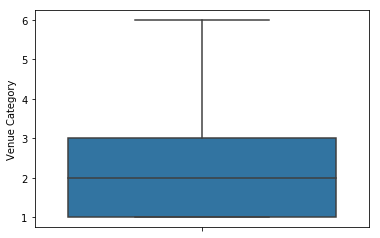

In [192]:
#now lets see how our restaurant data is distributed
sns.boxplot(data = nearby_restaurant_venues_count[['Neighborhood','Venue Category']], y='Venue Category')

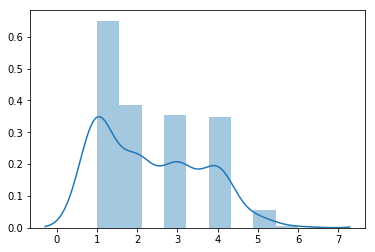

In [197]:
sns.distplot(nearby_restaurant_venues_count[['Venue Category']])

### We see there are very few pubs with >4 restaurants within 400m

##### Lets plot the location of these restaurants

In [205]:
nearby_restaurant_venues_count = nearby_restaurant_venues_count[nearby_restaurant_venues_count['Venue Category']>4]

latitude = nearby_restaurant_venues_count['Neighborhood Latitude']
longitude = nearby_restaurant_venues_count['Neighborhood Longitude']

# create map of using latitude and longitude values
pub_map = folium.Map(location=[latitude[0], longitude[0]], zoom_start=15)

# add markers to map
for lat, lng, name in zip(nearby_restaurant_venues_count['Neighborhood Latitude'], nearby_restaurant_venues_count['Neighborhood Longitude'], nearby_restaurant_venues_count['Neighborhood']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=250,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pub_map)  
    
pub_map